In [1]:
import pickle
import torch
import numpy as np
import pandas as pd
import gpytorch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


## loading the data from ../train_generations.pkl
with open('../generate_data/train_generations.pkl', 'rb') as f:
    data = pickle.load(f)
    print(type(data))
    data = pd.DataFrame(data)
 

<class 'dict'>


In [2]:
for key in sorted(data.keys()):
        for next_key in sorted(data[key].keys()):
            if next_key == "responses":
                response_data = (data[key][next_key])
                if not response_data:
                    continue
                first_response = response_data[0]
                print("AAAAAAAAAAAAAA")
                print(first_response)
                token_embeddings = first_response[2] 
                print("BBBBBBBBBBBBBBB")
                print(token_embeddings)
                print("AAAAAAAAAAAAAA")
                
                

AAAAAAAAAAAAAA
('Trumpets and trombones are most commonly pitched at Bb.', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.08954261988401413, 0.0, -0.3505175709724426], tensor([[-2.8837,  6.8692,  1.1943,  ..., -1.6161, -0.4493, -2.8256]]), 0.0)
BBBBBBBBBBBBBBB
tensor([[-2.8837,  6.8692,  1.1943,  ..., -1.6161, -0.4493, -2.8256]])
AAAAAAAAAAAAAA
AAAAAAAAAAAAAA
("Every good boy deserves favour' is a mnemonic in?", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], tensor([[-2.5785,  2.5525,  3.6656,  ..., -5.7184, -2.0659, -1.0848]]), 0.0)
BBBBBBBBBBBBBBB
tensor([[-2.5785,  2.5525,  3.6656,  ..., -5.7184, -2.0659, -1.0848]])
AAAAAAAAAAAAAA
AAAAAAAAAAAAAA
('John Lewis', [0.0, 0.0], tensor([[ 2.9588,  2.2058,  3.7353,  ..., -5.1753, -2.8140,  1.6127]]), 0.0)
BBBBBBBBBBBBBBB
tensor([[ 2.9588,  2.2058,  3.7353,  ..., -5.1753, -2.8140,  1.6127]])
AAAAAAAAAAAAAA
AAAAAAAAAAAAAA
('een Elizabeth II has always had corgis as pets. She has owned 30 corgis in her lifetime, according

In [3]:
# Let's assume df is already in memory
def extract_embeddings(df, limit=None):
    embeddings = []
    
    for key in sorted(data.keys()):
        for next_key in sorted(data[key].keys()):
            if next_key == "responses":
                try:
                    response_data = data[key][next_key]
                    response_data = data[key][next_key]
                    if not response_data:
                        continue
                    first_response = response_data[0]
                    token_embeddings = response_data[0][2]

                    if isinstance(token_embeddings, torch.Tensor) and token_embeddings.ndim == 2:
                        sentence_embedding = token_embeddings.mean(dim=0)
                        embeddings.append(sentence_embedding.detach().cpu())
                        
                    else:
                        continue
                except Exception as e:
                    print(f"Error processing {key}: {e}")
                    
                if limit and len(embeddings) >= limit:
                    break

    return torch.stack(embeddings)

In [4]:
X = extract_embeddings(data, limit=500)
X.shape
X[:,0]

tensor([-2.8837, -2.5785,  2.9588, -0.4431, -0.8964,  0.7622,  2.6762, -0.2654,
        -0.6629, -0.9027,  0.2070,  0.4519,  2.2880,  0.1334, -0.0379, -2.7482,
         0.5128, -0.4138,  0.8906,  1.4673,  0.9187, -0.7802, -4.8616,  0.7453,
        -0.7413, -0.3069, -0.4971, -0.6021,  2.3404,  4.2807,  0.9040, -0.8549,
        -0.3510, -1.4234, -0.2234,  0.0138, -0.8596,  0.1461,  1.2731,  2.0031,
         1.3819, -0.7740, -0.3666,  1.5284, -1.8600,  0.4769, -2.0194, -2.3914,
         3.2122,  0.3567, -2.1306,  1.6535, -0.1230,  1.1104, -0.5942, -0.1805,
        -2.5094,  1.7137,  0.0710, -0.6476,  3.5442,  0.4880,  1.3306, -0.1596,
        -1.3307,  1.6879,  0.5343,  2.3157, -3.6723, -2.2286,  0.9623, -1.3992,
        -1.4580,  2.0990, -1.7666,  1.6298, -0.9989,  1.1666,  4.0916, -1.0203,
         0.7294,  0.0271,  1.7605, -0.4508, -1.2626, -1.8950, -4.5726,  2.3025,
         0.6819, -0.5070,  0.9069, -1.2761, -2.6914, -1.2138,  0.9056,  1.2149,
         0.8802,  0.2142,  1.4944,  0.63

In [5]:
class GPLVMModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gplvm(X, latent_dim=2, n_inducing=30, num_iter=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use SVD-based PCA to initialize latent space
    U, S, V = torch.pca_lowrank(X, q=latent_dim)
    Z_init = X @ V[:, :latent_dim]
    Z_init = Z_init.to(device)

    # Target: only one dimension for now (1D regression problem)
    y = X[:, 0].to(device)

    # Define inducing points
    inducing_points = Z_init[:n_inducing]

    # Model
    model = GPLVMModel(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=0.01)

    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(Z_init)
        loss = -mll(output, y)
        loss.backward()
        if i % 50 == 0:
            print(f"Iter {i}: loss = {loss.item():.4f}")
        optimizer.step()

    return model, likelihood, Z_init, y



In [6]:
# Assume X is your (n_samples, embedding_dim) tensor
model, likelihood, Z_latent, y_observed = train_gplvm(X, latent_dim=2, num_iter=300)


# Z_latent is the learned 2D latent representation of LLM outputs

Iter 0: loss = 3.3277
Iter 50: loss = 2.5345
Iter 100: loss = 2.2457
Iter 150: loss = 2.1294
Iter 200: loss = 2.0749
Iter 250: loss = 2.0442


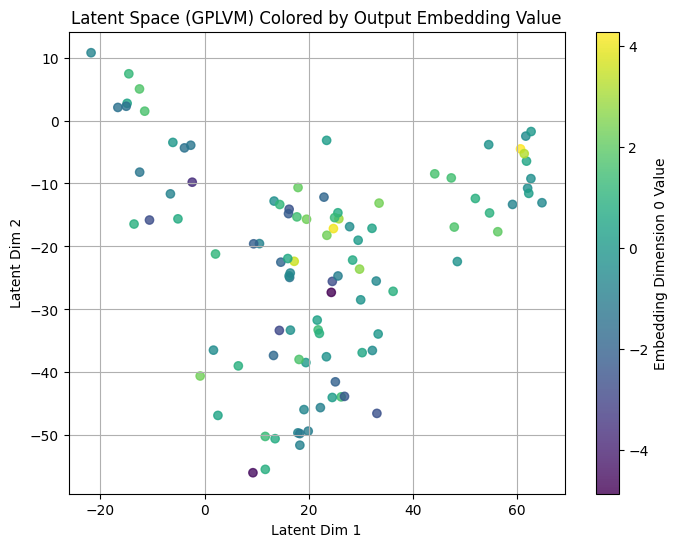

In [7]:
Z_plot = Z_latent.detach().cpu()
y_plot = y_observed.detach().cpu()

x_vals = Z_plot[:, 0].tolist()
y_vals = Z_plot[:, 1].tolist()
c_vals = y_plot.tolist()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_vals, y_vals, c=c_vals, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label="Embedding Dimension 0 Value")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.title("Latent Space (GPLVM) Colored by Output Embedding Value")
plt.grid(True)
plt.show()



In [8]:
model.eval()
likelihood.eval()

Z_np = Z_latent.detach().cpu()

# Create a grid in 2D latent space
x_min, x_max = Z_np[:, 0].min(), Z_np[:, 0].max()
y_min, y_max = Z_np[:, 1].min(), Z_np[:, 1].max()

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 100),
    torch.linspace(y_min, y_max, 100),
    indexing='ij'
)
Z_grid = torch.stack([xx.ravel(), yy.ravel()], dim=-1).to(Z_latent.device)

# Predict
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(Z_grid))
    mean = preds.mean.cpu().view(100, 100)
    stddev = preds.stddev.cpu().view(100, 100)


ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/contourpy/_contourpy.cpython-310-darwin.so, 0x0002): tried: '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/contourpy/_contourpy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/contourpy/_contourpy.cpython-310-darwin.so' (no such file), '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/contourpy/_contourpy.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))

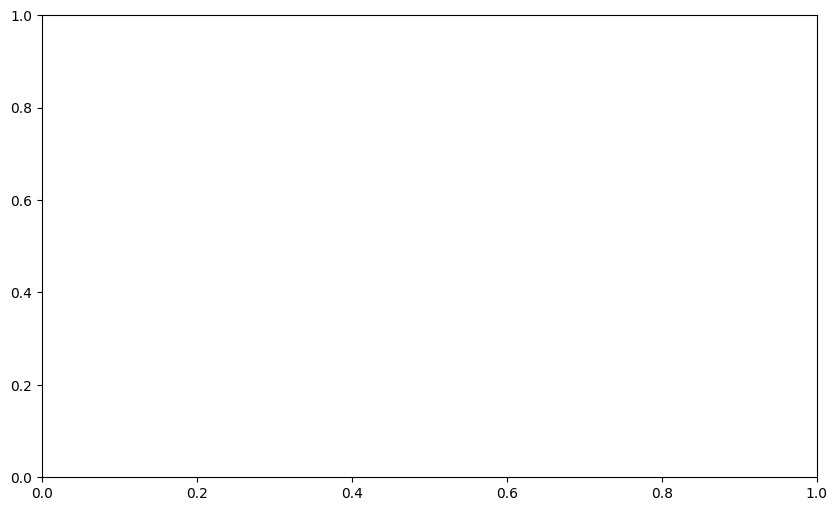

In [9]:
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, mean, levels=30, cmap="viridis")
plt.colorbar(label="Predicted Mean")
x_vals = Z_plot[:, 0].tolist()
y_vals = Z_plot[:, 1].tolist()
plt.scatter(x_vals, y_vals, c='white', s=10, alpha=0.7)
plt.title("GPLVM Posterior Mean")
plt.xlabel("Latent Dim 1")
plt.ylabel("Latent Dim 2")
plt.show()

## Loading the SBERT Embeddings and passing them in the GP model


In [10]:
embeds_path = "corpus_embeds_0.pkl"
corpus_embeds = torch.load(embeds_path, map_location=torch.device('cpu'))
corpus_embeds.shape

torch.Size([5, 384])

In [11]:
# Assume X is your (n_samples, embedding_dim) tensor
new_model, new_likelihood, new_Z_latent, new_y_obs = train_gplvm(corpus_embeds, latent_dim=2, n_inducing=3, num_iter=100)

Iter 0: loss = 1.2384
Iter 50: loss = 0.7859


## Visuals

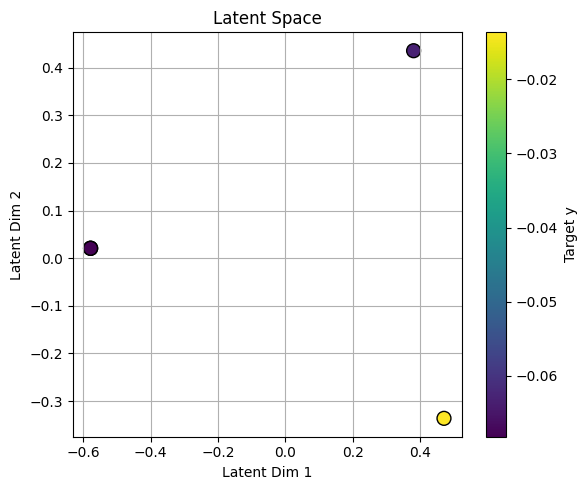

In [12]:
def plot_latent_space_torch(Z, y, title='Latent Space'):
    Z = Z.detach().cpu()
    y = y.detach().cpu()

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(scatter, label='Target y')
    plt.title(title)
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_latent_space_torch(new_Z_latent, new_y_obs)

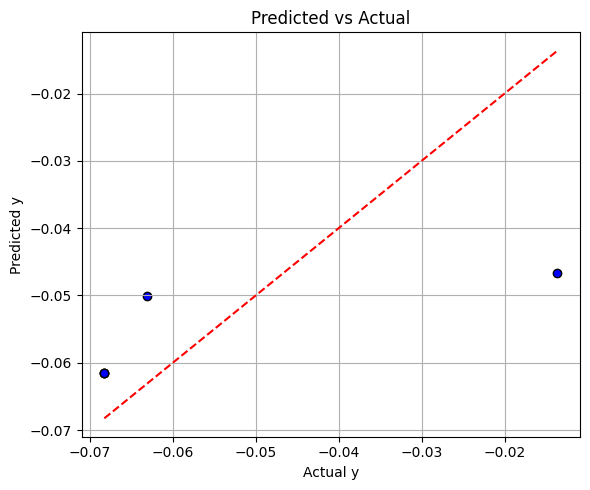

In [13]:
def plot_predictions(model, likelihood, Z, y_true):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(Z))
        y_pred = preds.mean

    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    plt.figure(figsize=(6, 5))
    plt.scatter(y_true, y_pred, c='blue', edgecolors='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.title('Predicted vs Actual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(new_model, new_likelihood, new_Z_latent, new_y_obs)


In [14]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, likelihood, Z, y_true):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(Z))
        y_pred = preds.mean

    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

evaluate_model(new_model, new_likelihood, new_Z_latent, new_y_obs)



RMSE: 0.0167
R² Score: 0.3915


/Users/zehaannaik/Library/Python/3.10/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Statistics

In [15]:
def check_latent_space(Z, y):
    Z = Z.detach().cpu()
    y = y.detach().cpu()
    print("Latent space shape:", Z.shape)
    print("y shape:", y.shape)
    print("First 5 points in latent space and their y values:")
    for i in range(min(5, Z.size(0))):
        print(f"Z[{i}]: {Z[i].tolist()} → y: {y[i].item():.4f}")

check_latent_space(new_Z_latent, new_y_obs)


Latent space shape: torch.Size([5, 2])
y shape: torch.Size([5])
First 5 points in latent space and their y values:
Z[0]: [-0.5782293677330017, 0.02087382972240448] → y: -0.0683
Z[1]: [0.470937043428421, -0.3361600637435913] → y: -0.0136
Z[2]: [-0.5782293677330017, 0.02087382972240448] → y: -0.0683
Z[3]: [-0.5782293677330017, 0.02087382972240448] → y: -0.0683
Z[4]: [0.380730539560318, 0.43569415807724] → y: -0.0631


In [16]:
def check_predictions(model, likelihood, Z, y_true):
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(Z))
        y_pred = preds.mean

    y_true = y_true.detach().cpu()
    y_pred = y_pred.detach().cpu()

    print("First few predictions:")
    for i in range(min(5, y_true.shape[0])):
        print(f"True: {y_true[i].item():.4f} — Predicted: {y_pred[i].item():.4f}")

check_predictions(new_model, new_likelihood, new_Z_latent, new_y_obs)

First few predictions:
True: -0.0683 — Predicted: -0.0616
True: -0.0136 — Predicted: -0.0467
True: -0.0683 — Predicted: -0.0616
True: -0.0683 — Predicted: -0.0616
True: -0.0631 — Predicted: -0.0501
